In [1]:

import argparse, retro, threading, os, numpy, random, math
from Agent import Agent
from DefaultMoveList import Moves
from collections import deque
import numpy as np

2023-01-08 05:30:06.622148: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-08 05:30:06.780228: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-08 05:30:07.572675: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.8/site-packages/torch/lib:/opt/conda/lib/python3.8/site-packages

In [2]:
# import tensorflow as tf
# from tensorflow.python import keras
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.optimizers import Adam
# from keras.models import load_model
# from keras import backend as K
# import keras.losses


In [3]:
import sys
sys.path.append('/home/decision-transformer/atari')
import csv
import logging
# make deterministic
from mingpt.utils import set_seed
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import math
from torch.utils.data import Dataset
from mingpt.model_style_street import GPT, GPTConfig
#from mingpt.trainer_style_street import StyleTrainer, StyleTrainerConfig
from mingpt.utils import style_sample
from collections import deque
import random
import torch
import pickle
import blosc
import argparse
from create_dataset import create_dataset,create_dataset_rwds
import numpy as np

# apt-get update && apt-get install libgl1
# to solve the issue "libGL.so.1: cannot open shared object file: No such file or directory"

/home/street_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
class DTAgent(Agent):
    """An agent that implements the Decison Transformer Reinforcement Algorithm to learn street fighter 2"""
    
    # Mapping between player state values and their one hot encoding index
    stateIndices = {512 : 0, 514 : 1, 516 : 2, 518 : 3, 520 : 4, 522 : 5, 524 : 6, 526 : 7, 532 : 8} 
    doneKeys = [0, 528, 530, 1024, 1026, 1028, 1030, 1032]

    ACTION_BUTTONS = ['X', 'Y', 'Z', 'A', 'B', 'C']


    def __init__(self, stateSize= 32, load= False, epsilon= 1, name= None, moveList= Moves):
        """Initializes the agent and the underlying neural network

        Parameters
        ----------
        stateSize
            The number of features that will be fed into the Agent's network

        load
            A boolean flag that specifies whether to initialize the model from scratch or load in a pretrained model

        epsilon
            The initial exploration value to assume when the model is initialized. If a model is lodaed this is set
            to the minimum value

        name
            A string representing the name of the agent that will be used when saving the model and training logs
            Defaults to the class name if none is provided

        moveList
            An enum class that contains all of the allowed moves the Agent can perform

        Returns
        -------
        None
        """
        self.stateSize = stateSize
        self.actionSize = len(moveList)
        self.actions = []
        self.masked = True
        self.style = 0 #1,2,3,4
        self.all_state = None
        self.rtgs = []
        self.ret = 606.0
        self.index = 0
        super(DTAgent, self).__init__(load= load, name= name, moveList= moveList) 

    def getMove(self, obs, info):
        """Returns a set of button inputs generated by the Agent's network after looking at the current observation

        Parameters
        ----------
        obs
            The observation of the current environment, 2D numpy array of pixel values

        info
            An array of information about the current environment, like player health, enemy health, matches won, and matches lost, etc.
            A full list of info can be found in data.json

        Returns
        -------
        move
            An integer representing the move selected from the move list

        frameInputs
            A set of frame inputs where each number corresponds to a set of button inputs in the action space.
        """        
        style = torch.tensor([self.style], dtype=torch.int64).unsqueeze(1)
        stateData = torch.tensor(self.prepareNetworkInputs(info)).type(torch.float32).unsqueeze(0)
        if self.index == 0:
            if self.masked:
                self.ret = 0
            self.rtgs = [self.ret]
            # first state is from env, first rtg is target return, and first timestep is 0
            sampled_action = style_sample(self.model, stateData, 1, temperature=1.0, sample=True, actions=None, 
                rtgs=torch.tensor(self.rtgs, dtype=torch.long).unsqueeze(0).unsqueeze(-1), 
                timesteps=torch.zeros((1, 1, 1), dtype=torch.int64),style=style)
            
            self.all_states = stateData
        else:
            reward = self.memory[-1][Agent.REWARD_INDEX]
            print(self.index-1, reward)
            self.all_states = torch.cat([self.all_states, stateData], dim=0)
            if self.masked:
                self.rtgs += [0]
            else:
                reward = self.memory[-1][Agent.REWARD_INDEX]
                self.rtgs += [self.rtgs[-1] - reward]
            # all_states has all previous states and rtgs has all previous rtgs (will be cut to block_size in utils.sample)
            # timestep is just current timestep
            sampled_action = style_sample(self.model, self.all_states.unsqueeze(0), 1, temperature=1.0, sample=True, 
                    actions=torch.tensor(self.actions, dtype=torch.long).unsqueeze(1).unsqueeze(0), 
                    rtgs=torch.tensor(self.rtgs, dtype=torch.long).unsqueeze(0).unsqueeze(-1), 
                    timesteps=(min(self.index, 7734) * torch.ones((1, 1, 1), dtype=torch.int64)),style=style)
        self.actions += [sampled_action]
        action = sampled_action.cpu().numpy()[0,-1]
        self.index += 1
        frameInputs = self.convertMoveToFrameInputs(list(self.moveList)[action], info) 
        return action, frameInputs


    def initializeNetwork(self):
        """Initializes a Neural Net for a DT Model
        
        Parameters   
        ----------
        None

        Returns
        -------
        model
            The initialized neural network model that Agent will interface with to generate game moves
        """
        # 28 150 reward_conditioned 7734
        masked = self.masked
        mconf = GPTConfig(28, 150,
                  n_layer=6, n_head=8, n_embd=128, model_type='reward_conditioned', max_timestep=7734, style_num=5, mask=masked)
        model = GPT(mconf)
        if masked:
            model_path = '/home/decision-transformer/atari/style_ckpt_dir_street/5_styles_masked/StreetFigh-reward_conditioned-traj_num-152-maxtimestep-7734-SEED-520-EPOCH-50-Masked-True.pth'
        else:
            model_path = '/home/decision-transformer/atari/style_ckpt_dir_street/5_styles_normal/StreetFigh-reward_conditioned-traj_num-152-maxtimestep-7734-SEED-520-EPOCH-50-Masked-False.pth'
        model.load_state_dict(torch.load(model_path), strict=False)
        model.train(False)
        print('Successfully initialized model')
        return model
    
    
    def reviewFight(self):
        """The Agent goes over the data collected from it's last fight, prepares it, and then runs through one epoch of training on the data"""
        self.all_state = None
        self.rtgs = []
        self.index = 0
        self.actions = []
        cul_epo_return = []
        for step in self.memory:
            cul_epo_return.append(step[Agent.REWARD_INDEX])
        print(f"Currently, the avg reward is {np.average(cul_epo_return)}, total return is {np.sum(cul_epo_return)}")
        self.prepareForNextFight()
        
        
    def prepareMemoryForTraining(self, memory):
        """prepares the recorded fight sequences into training data
        
        Parameters
        ----------
        memory
            A 2D array where each index is a recording of a state, action, new state, and reward sequence
            See readme for more details

        Returns
        -------
        data
            The prepared training data in whatever from the model needs to train
            DeepQ needs a state, action, and reward sequence to train on
            The observation data is thrown out for this model for training
        """
        data = []
        epo_return = 0
        time_index = 0
        cul_epo_return = []
        for step in self.memory:
            data.append(
            [self.prepareNetworkInputs(step[Agent.STATE_INDEX]), 
            step[Agent.ACTION_INDEX], 
            step[Agent.REWARD_INDEX],
            step[Agent.DONE_INDEX],
            self.prepareNetworkInputs(step[Agent.NEXT_STATE_INDEX])])

            self.obss.append(self.prepareNetworkInputs(step[Agent.STATE_INDEX]))
            self.actions.append(step[Agent.ACTION_INDEX])
            cul_epo_return.append(epo_return)
            epo_return += step[Agent.REWARD_INDEX]
            self.current_index += 1
            self.timesteps.append(time_index)
            time_index += 1
            self.stepwise_returns.append(step[Agent.REWARD_INDEX])

        for ele in cul_epo_return:
            self.rtg.append(epo_return - ele)
        self.returns.append(epo_return)
        self.done_idxs.append(self.current_index)
        self.num_trajectories += 1
        print("Saving to File ----> "+ "Trajs: " + str(self.num_trajectories)+ '; trans: '+ str(self.current_index)+".npz ....")
        dir_name = '/home/AIVO-StreetFigherReinforcementLearning/local_savefiles_splited/'
        np.savez(dir_name+"Day:2022_12_29_splitedbyepisode2; trajs: " + str(self.num_trajectories)+ '; trans: '+ str(self.current_index), obss=np.array(self.obss), actions=np.array(self.actions), returns=np.array(self.returns), done_idxs=np.array(self.done_idxs), rtg=np.array(self.rtg), timesteps=np.array(self.timesteps), rewards=np.array(self.stepwise_returns)) 
        self.obss = []
        self.actions = []
        self.returns = []
        self.done_idxs = []
        self.stepwise_returns = []
        self.timesteps = []
        self.rtg = []
        return data

    def prepareNetworkInputs(self, step):
        """Generates a feature vector from the current game state information to feed into the network
        
        Parameters
        ----------
        step
            A given set of state information from the environment
            
        Returns
        -------
        feature vector
            An array extracted from the step that is the same size as the network input layer
            Takes the form of a 1 x 30 array. With the elements:
            enemy_health, enemy_x, enemy_y, 8 one hot encoded enemy state elements, 
            8 one hot encoded enemy character elements, player_health, player_x, player_y, and finally
            8 one hot encoded player state elements.
        """
        feature_vector = []
        
        # Enemy Data
        feature_vector.append(step["enemy_health"])
        feature_vector.append(step["enemy_x_position"])
        feature_vector.append(step["enemy_y_position"])

        # one hot encode enemy state
        # enemy_status - 512 if standing, 514 if crouching, 516 if jumping, 518 blocking, 522 if normal attack, 524 if special attack, 526 if hit stun or dizzy, 532 if thrown
        oneHotEnemyState = [0] * len(DTAgent.stateIndices.keys())
        if step['enemy_status'] not in DTAgent.doneKeys: oneHotEnemyState[DTAgent.stateIndices[step["enemy_status"]]] = 1
        feature_vector += oneHotEnemyState

        # one hot encode enemy character
        oneHotEnemyChar = [0] * 8
        oneHotEnemyChar[step["enemy_character"]] = 1
        feature_vector += oneHotEnemyChar

        # Player Data
        feature_vector.append(step["health"])
        feature_vector.append(step["x_position"])
        feature_vector.append(step["y_position"])

        # player_status - 512 if standing, 514 if crouching, 516 if jumping, 520 blocking, 522 if normal attack, 524 if special attack, 526 if hit stun or dizzy, 532 if thrown
        oneHotPlayerState = [0] * len(DTAgent.stateIndices.keys())
        if step['status'] not in DTAgent.doneKeys: oneHotPlayerState[DTAgent.stateIndices[step["status"]]] = 1
        feature_vector += oneHotPlayerState

        feature_vector = numpy.reshape(feature_vector, [1, self.stateSize])
        return feature_vector

    def trainNetwork(self, data, model):
        """To be implemented in child class, Runs through a training epoch reviewing the training data
        Parameters
        ----------
        data
            The training data for the model to train on, a 2D array of state, action, reward, sequence

        model
            The model to train and return the Agent to continue playing with
        Returns
        -------
        model
            The input model now updated after this round of training on data
        """
        
        return self.model

In [5]:
class Args:
    def __init__(self):
        self.device = torch.device('cuda')
        self.render = True
        self.episodes = 1
        self.load = False
        self.name = None

In [6]:
# apt-get install -y xvfb python-opengl ffmpeg ""##to show the video
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

from pyvirtualdisplay import Display

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    
display = Display(visible=0, size=(1400, 900))
display.start()

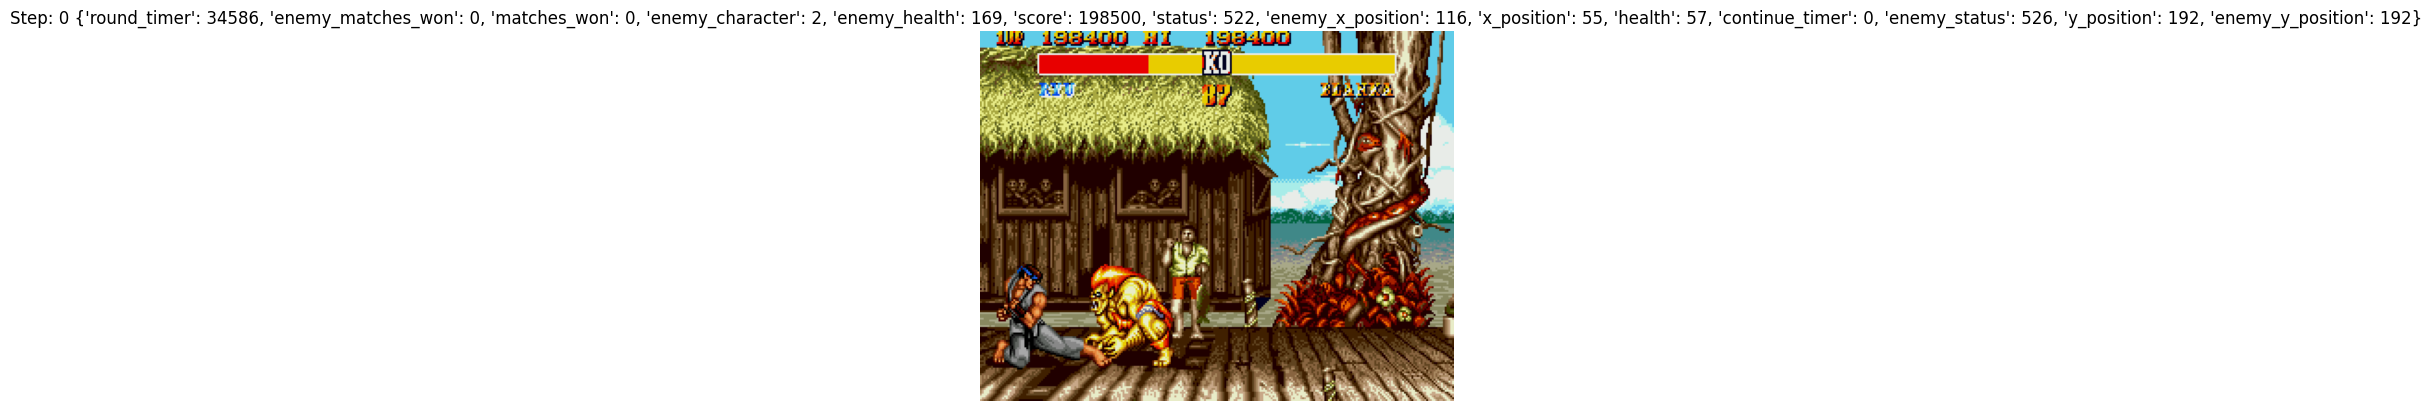

In [ ]:
# parser = argparse.ArgumentParser(description= 'Processes agent parameters.')
# parser.add_argument('-r', '--render', default=False, action= 'store_true', help= 'Boolean flag for if the user wants the game environment to render during play')
# parser.add_argument('-l', '--load', default=False, action= 'store_true', help= 'Boolean flag for if the user wants to load pre-existing weights')
# parser.add_argument('-e', '--episodes', type= int, default= 10, help= 'Intger representing the number of training rounds to go through, checkpoints are made at the end of each episode')
# parser.add_argument('-n', '--name', type= str, default= None, help= 'Name of the instance that will be used when saving the model or it\'s training logs')
# args = parser.parse_args()
args = Args()
qAgent = DTAgent(load= args.load, name= args.name)

from Lobby import Lobby
testLobby = Lobby(render= args.render)
testLobby.addPlayer(qAgent)
testLobby.executeTrainingRun(episodes= args.episodes)

In [ ]:
show_video()